<img src="./images/logo-ensae.jpg" width = 40%><img src="./images/logo-ipparis.jpg" width = 30%>

**"Statistical Analysis of Network Data with applications in Marketing", S2 2018-19** 
# *Fake News Network Analysis* - R Code  

**Santiago CÓRDOBA MUÑOZ**, *Mastère Spécialisé Data Science, ENSAE ParisTech*  
**Yosuke IJIRI**, *Mastère Spécialisé Data Science, ENSAE ParisTech*  

## Overview
1. Data Preparation  
2. Descriptive Analysis

## 1. Data Preparation

In [2]:
# Read necessary libraries
#install.packages("igraph")
#install.packages("png")
#install.packages("jpeg")
#install.packages("dplyr")
#install.packages("sna")
#install.packages("network")
library(igraph, warn.conflicts = FALSE)
library(ggplot2)
library(stringr)
library(png)
library(jpeg)
library(dplyr, warn.conflicts = FALSE)
library(sna)
library(network)

### 1.1. PolitiFact_real_news_content.csv  
(Unfortunately, "PolitiFact_fake_news_content.csv" was not the correct dataset.)

[1] 120

[1] "id"             "title"          "text"           "url"           
 [5] "top_img"        "authors"        "source"         "publish_date"  
 [9] "movies"         "images"         "canonical_link" "meta_data"

,News ID,publish_date
24,12,{'$date': 1474368432000}


TITLE: 

[1] Trump needles Clinton: ‘Sleep well Hillary — see you at the debate!’
114 Levels: 'Locked the black bitch out': White students under investigation after racist Snapchat reveals campus harassment ...

TEXT: Donald Trump mocked Hillary Clinton's planes and needled her for "taking the day off." | Getty Trump needles Clinton: ‘Sleep well Hillary — see you at the debate!’

Hillary Clinton is a copycat who’s probably sleeping because she needs to rest, Donald Trump suggested Tuesday.

In a pair of tweets bookended by a post announcing “two big rallies” in North Carolina, Trump accused the Democratic presidential nominee of “copying my airplane” and continued his assault over her stamina, or alleged lack thereof.

Story Continued Below

“Do people notice Hillary is copying my airplane rallies — she puts the plane behind her like I have been doing from the beginning,” Trump mused in a tweet Tuesday morning.

“Hillary Clinton is taking the day off again, she needs the rest,” he added minutes later. “Sleep well Hillary — see you at the debate!”

Trump’s critical comments come shortly after Clinton warned voters during a radio interview with Steve Harvey, “The next 50 days will determine the 

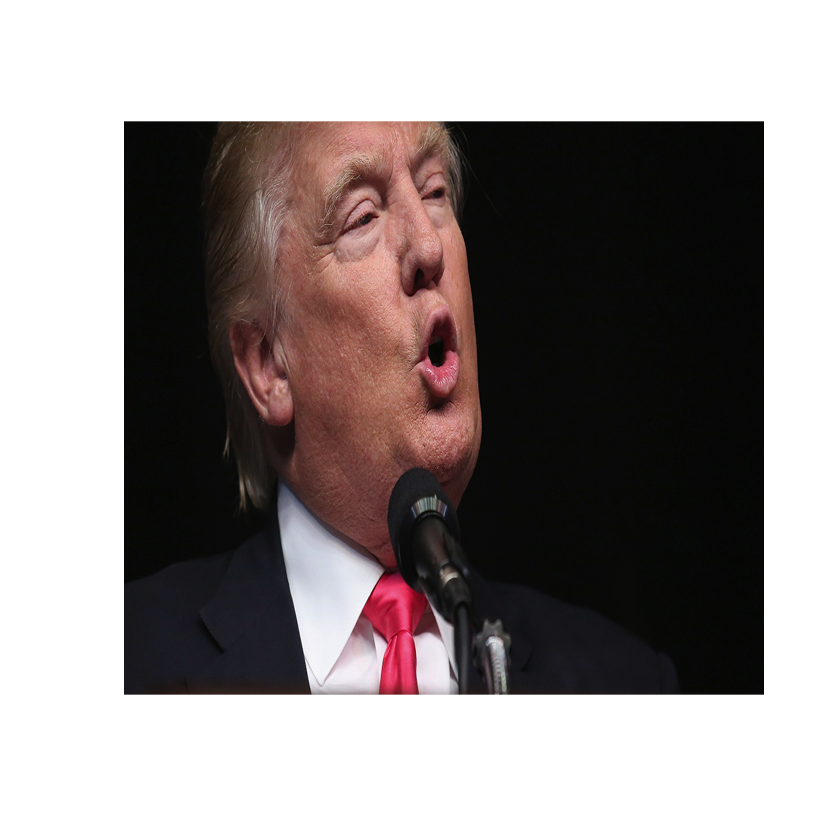

In [3]:
# Read the file and add a column of News ID
content <- read.csv("./fakenewsnet/PolitiFact_real_news_content.csv", header=TRUE)
nrow(content)
names(content)
content["News ID"] <- NA
content <- content[c('id', 'News ID', 'title', 'text', 'url',
                     'top_img', 'authors', 'source', 'publish_date', 'movies',
                     'images', 'canonical_link', 'meta_data')]
content["News ID"] <- sapply(content$id, function(x){return (as.numeric(str_extract(x, "[0-9.]+")))})

# Show a sample real news content
id <- 12  # Choose a News ID of your choice
content[which(content[,2] == id), c(2, 9)]
cat("TITLE: ")
content[which(content[,2] == id), 3]
cat("TEXT: ")
cat(toString(content[which(content[,2] == id), 4]))
img_path <- toString(content[which(content[,2] == id), 6])
download.file(img_path,'./data/sample.jpg', mode = 'wb')
jj <- readJPEG("./data/sample.jpg",native=TRUE)
plot(0:1,0:1,type="n",ann=FALSE,axes=FALSE)
rasterImage(jj,0,0,1,1)

### 1.2. PolitiFactUser.txt

In [4]:
# User data: row num = index
users <- read.table("./fakenewsnet/PolitiFactUser.txt", header=FALSE)
cat("Number of User IDs:", nrow(users), "\n")
cat("Number of unique User IDs:", nrow(unique(users)))
users["ID"] <- NA 
users$ID <- seq(1, nrow(users))
users <- users[c("ID", "V1")]
head(users, 5)

Number of User IDs: 23865 
Number of unique User IDs: 23865

ID,V1
1,f4b46be21c2f553811cc8a73c4f0ff05
2,2ced3734cc9c164edd9a8f5fbebe976f
3,c84c4ea8ba67211f84781bdd64cafe43
4,1776d1765f5e82cd660d8d502f227402
5,4e8c2c300d96929895ce0edba915af16


### 1.3. PolitiFactNews.txt

In [5]:
# e.g. ‘PolitiFact_Real_1' is in the 1st row, so it's corresponding to index 1.
news <- read.table("./fakenewsnet/PolitiFactNews.txt", header=FALSE)
cat("Number of real news:", sum(grepl("PolitiFact_Real", news[,1])), "\n")
cat("Number of fake news:", sum(grepl("PolitiFact_Fake", news[,1])))
news["ID"] <- NA 
news$ID <- seq(1, nrow(news))
news <- news[c("ID", "V1")]
head(news, 5)

Number of real news: 120 
Number of fake news: 120

ID,V1
1,PolitiFact_Real_1
2,PolitiFact_Real_2
3,PolitiFact_Real_3
4,PolitiFact_Real_4
5,PolitiFact_Real_5


### 1.4. PolitiFactNewsUser.txt

In [6]:
# e.g. '240 1 1' means news 240 is posted/spreaded by user 1 for 1 time.
newsuser <- read.table("./fakenewsnet/PolitiFactNewsUser.txt", header=FALSE)
cat("Number of rows:", nrow(newsuser))
newsuser["Real_Fake"] <- NA
newsuser <- newsuser[c("V1", "Real_Fake", "V2", "V3")]
names(newsuser) <- c("News ID", "Real_Fake", "User ID", "Number_of_Posts")

# Add a column of Real/Fake for the corresponding News IDs
for(i in 1:nrow(newsuser)){
    if (grepl("Real", news[newsuser[i,1],2])){
        newsuser[i, "Real_Fake"] <- "Real"}
    else {
        newsuser[i, "Real_Fake"] <- "Fake"}
    }

head(newsuser, 5)

Number of rows: 32791

News ID,Real_Fake,User ID,Number_of_Posts
240,Fake,1,1
124,Fake,2,1
162,Fake,3,1
233,Fake,4,1
50,Real,5,1


#### 1.4.1. Simple statistics of *newsuser*

- 28881 fake news posted by the users

In [7]:
newsuser %>%
    group_by(Real_Fake) %>% 
    summarize('Sum_Posts' = sum(Number_of_Posts))

Real_Fake,Sum_Posts
Fake,28881
Real,8378


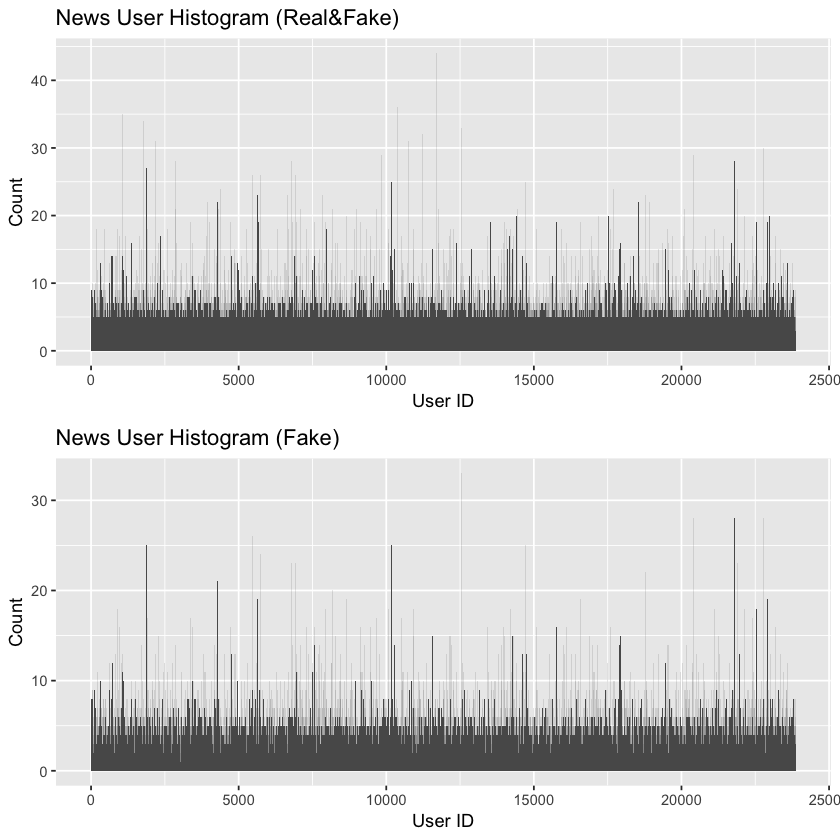

In [13]:
# Do some simple analysis of the newsuser data here (e.g. Who spreads fake news the most, etc.)

# Histogram of the users in the data
h1 <- ggplot(newsuser, aes(x = newsuser[,3]))
h1 <- h1 + geom_histogram(binwidth=5) + labs(title='News User Histogram (Real&Fake)', x='User ID', y='Count')
ggsave("./data/newsuser_histogram_realfake.png", width=10.5,height=4.5)
temp = data.frame(fakes = newsuser[which(newsuser[,2]=='Fake'),3])
h2 <- ggplot(temp, aes(x = fakes))
h2 <- h2 + geom_histogram(binwidth=5) + labs(title='News User Histogram (Fake)', x='User ID', y='Count')
ggsave("./data/newsuser_histogram_fake.png", width=10.5,height=4.5)
gridExtra::grid.arrange(h1, h2)

### 1.5. PolitiFactUserUser.txt

In [9]:
# Read the follower/following properties (edge list) for the PolitiFact data.
# e.g. ’1589 1' means user 1589 is following user 1
edge_list <- read.table("./fakenewsnet/PolitiFactUserUser.txt", header=FALSE)
nrow(edge_list)
head(edge_list, 5)

[1] 574744

V1,V2
507,1
1589,1
5307,1
11421,1
13267,1


In [10]:
# Read the list as the igraph format
g <- graph.data.frame(edge_list, directed=TRUE)

## 2. Descriptive Analysis

In [11]:
# To check if our graph is simple, meaning absence of loops and multi-edges
is.simple(g)

[1] FALSE

In [12]:
# Remove redundant edges and looping edges.
g <- simplify(g, remove.multiple=T, remove.loops=T)
is.simple(g)

[1] TRUE

### 2.1 Network Visualization

pdf 
  2

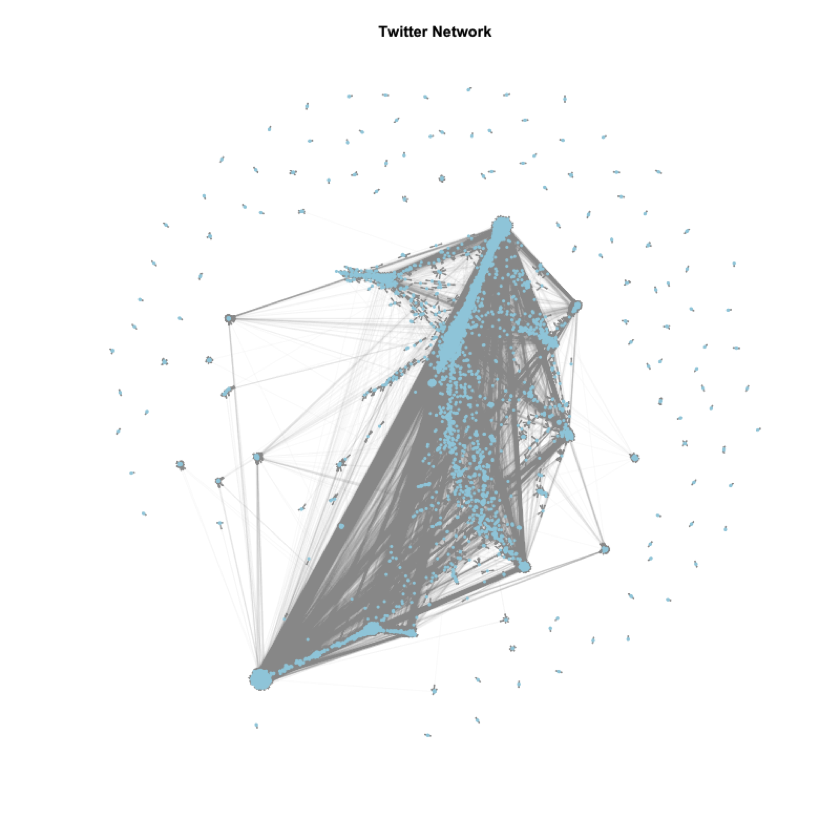

In [71]:
# Plot the graph
png("./data/network_visualization.png", 800, 800)
plot(g, vertex.label=NA, vertex.size=1, vertex.frame.color=NA, vertex.color="lightblue",
     edge.width=0.05, edge.arrow.size=0.3, edge.arrow.width=0.3,
     layout=layout_nicely)
title("Twitter Network")
dev.off()
img <- readPNG('./data/network_visualization.png')
grid::grid.raster(img)

In [10]:
# To check the Edge sequence
E(g)

+ 574742/574742 edges from b072d0d (vertex names):
 [1] 507 ->21496 507 ->11647 507 ->5169  507 ->1     1589->22982 1589->488  
 [7] 1589->1210  1589->1133  1589->2090  1589->14523 1589->18025 1589->19895
[13] 1589->15013 1589->3731  1589->7480  1589->10072 1589->6057  1589->16866
[19] 1589->19005 1589->22985 1589->21195 1589->22637 1589->16246 1589->14309
[25] 1589->6787  1589->6977  1589->9863  1589->10356 1589->12071 1589->12584
[31] 1589->17392 1589->19134 1589->19470 1589->20639 1589->22672 1589->23581
[37] 1589->727   1589->2856  1589->3903  1589->10034 1589->10692 1589->10714
[43] 1589->10881 1589->11552 1589->13583 1589->13899 1589->14541 1589->14547
[49] 1589->15941 1589->19676 1589->21713 1589->21952 1589->23852 1589->18695
[55] 1589->3283  1589->13208 1589->4233  1589->5657  1589->6697  1589->11789
+ ... omitted several edges

In [ ]:
# To create the matrix of the network
g[]

In [ ]:
#To check the attributes of the edges
edge_attr(g)
vertex_attr(g)

In [17]:
# To check if the graph is weighted
is.weighted(g)

[1] FALSE

In [20]:
# To check if it is connected, meaning if every vertex is reachable from every other.
is.connected(g)

[1] FALSE

In [22]:
# To check if it is strongly connected, It is called strongly connected 
#if every vertex v is reachable from every u by a directed walk.
is.connected(g,mode="strong")

[1] FALSE

In [21]:
# To check if it is weakly connected, it means if its underlying graph
# (i.e., the result of stripping away the labels `tail' and `head' from G) is
# connected
is.connected(g,mode="weak")

[1] FALSE

In [23]:
# To see the diameter of the graph. The value of the longest distance in a graph is called the diameter of the
#graph.
diameter(g)

[1] 14

In [ ]:
# To get the adjency matrix
get.adjacency(g)

In [ ]:
######### I don't see a particular use to the below part##################
#--------------------------------------------------------------------------
# Histogram of the degree is the number of vertices in V incident to v.
hist(degree(g), col="lightblue",xlab="Vertex Degree",ylab="Frequency",main="")

# Histrogram of the strenght
hist(graph.strength(g), col="pink", xlab="Vertex Strength",ylab="Frequency",main="")
#----------------------------------------------------------------------------

A <- get.adjacency(g)

# It doesn't run in my computer, problems of allocation size.
ga <- as.network.matrix(A)

# To do a graph of centrality, we need ga in order to run it
gplot.target(g,degree(g),main="Degree",circ.lab = FALSE, circ.col="skyblue",usearrows = FALSE,ertex.col=c("blue",rep("red",32),"yellow"),edge.col="darkgray")

In [ ]:
###########################################
####### Network and node descriptives######
###########################################

# To get the proportion of present edges from all possible edges in the network.
edge_density(g, loops=F)

# To get the proportion of reciprocated ties (for a directed network).
reciprocity(g)
dyad_census(g) # Mutual, asymmetric, and null node pairs

# To get ratio of triangles (direction disregarded) to connected triples.
transitivity(g, type="global") # net is treated as an undirected network

# To get ratio of triangles to connected triples each vertex is part of.
transitivity(g, type="local")

# Node degree
deg <- degree(g, mode="all")
plot(g, vertex.size=deg*3)
hist(deg, breaks=1:vcount(g)-1, main="Histogram of node degree")

# Degree distribution
deg.dist <- degree_distribution(g, cumulative=T, mode="all")
plot( x=0:max(deg), y=1-deg.dist, pch=19, cex=1.2, col="orange",xlab="Degree", ylab="Cumulative Frequency")

# Centralization, and theoretical_max - maximum centralization score for a graph of that size.
degree(g, mode="in")
centr_degree(g, mode="in", normalized=T)

# To get the mean of the shortest distance between each pair of nodes in the network (in both directions for directed graphs)
mean_distance(g, directed=F)
mean_distance(g, directed=T)

# The codes with '!!' take long time to execute
# !! Community detection
ceb <- cluster_edge_betweenness(g)
plot(ceb, g)

class(ceb)
# !! number of communities
length(ceb)

# !! community membership for each node
membership(ceb)

# !! High modularity for a partitioning reflects dense connections within communities and sparse
# connections across communities.
modularity(ceb)

## Matching of attributes across connected nodes more than expected by chance
assortativity(net, V(net)$audience.size, directed=F)

## Reference
- Combating Fake News: A Survey on Identification and Mitigation Techniques/
Arizona Board of Regents https://github.com/KaiDMML/FakeNewsNet
- Data Source: Kaggle: FakeNewsNet https://www.kaggle.com/mdepak/fakenewsnet